In [14]:
import mne
import peak_frequency as pf
import matplotlib.pyplot as plt

Opening raw data file data/S2/S2_4chns.raw...
Isotrak not found
    Range : 0 ... 1507179 =      0.000 ...  3014.358 secs
Ready.
Reading 0 ... 1507179  =      0.000 ...  3014.358 secs...


<ipython-input-14-dfd5fffffa63>:4: RuntimeWarning: This filename (data/S2/S2_4chns.raw) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.Raw(fname, preload=True)


In [31]:
fname = 'data/S2/S2_4chns.raw'
raw = mne.io.Raw(fname, preload=True)
data = raw.get_data()

Opening raw data file data/S2/S2_4chns.raw...
Isotrak not found
    Range : 0 ... 1507179 =      0.000 ...  3014.358 secs
Ready.
Reading 0 ... 1507179  =      0.000 ...  3014.358 secs...


<ipython-input-31-547077fe7706>:2: RuntimeWarning: This filename (data/S2/S2_4chns.raw) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.Raw(fname, preload=True)


In [55]:
#c3 = raw['C3']
#c4 = raw['C4']
#samples = data.shape[1]
fs = 500
channels = 4
samples = 900
bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 45)}

In [33]:
data = data.T

{'delta': array([0., 0., 0., 0.]), 'theta': array([-1.10435926e-13, -1.10435926e-13, -1.41357986e-13,  1.65653890e-13]), 'alpha': array([5., 5., 5., 5.]), 'beta': array([11.98021232, 14.54490235, 13.97197963, 11.45926121]), 'gamma': array([33.94183302, 30.89870107, 31.71164518, 35.40588378])}


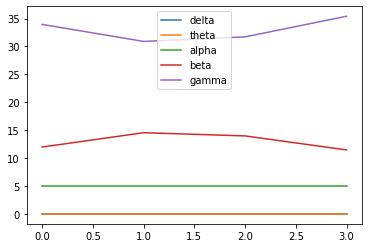

In [38]:
peak = pf.PeakFrequency(channels, samples, fs, bands)
features = peak.fit(data[:samples, :])
print(features)


for key, val in features.items():
    plt.plot(val, label=key)
plt.legend()
plt.show()

{'delta': (1, 4), 'theta': (8, 9), 'alpha': (9, 10), 'beta': (10, 12), 'gamma': (30, 45)}
42.35058014033825 0
{'delta': (1, 4), 'theta': (9, 8), 'alpha': (8, 10), 'beta': (10, 10), 'gamma': (30, 45)}
37.24021205201431 42.35058014033825
34.440190646264824 0
34.19684245710411 34.440190646264824
43.53401616129118 34.440190646264824
58.19778032787697 43.53401616129118
59.021682894630594 58.19778032787697
{'delta': array([0., 0., 0., 0.]), 'theta': array([-1.10435926e-13, -1.10435926e-13, -1.41357986e-13,  1.65653890e-13]), 'alpha': array([5., 5., 5., 5.]), 'beta': array([11.98021232, 14.54490235, 13.97197963, 11.45926121]), 'gamma': array([33.94183302, 30.89870107, 31.71164518, 35.40588378])}
{'delta': (1, 4), 'theta': (7, 9), 'alpha': (9, 14), 'beta': (14, 14), 'gamma': (30, 45)}


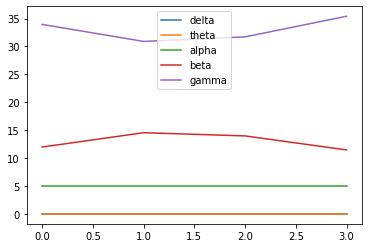

In [56]:
def optimize_alpha(bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 45)}, 
                   lower=9, upper=10, lower_bound=7, upper_bound=15):
    best_score = 0
    best_lower = lower
    best_upper = upper
    
    while lower > lower_bound : 
        bands['alpha'] = (lower, upper)
        bands['beta'] = (upper, bands['beta'][0])
        bands['theta'] = (bands['theta'][1], lower)
        peakf = pf.PeakFrequency(channels, samples, fs, bands)
        scores = peakf.fit(data[:samples, :])
        score = scores['alpha'][0]*scores['alpha'][1]/2
        print(bands)
        print(score, best_score)
        if score > best_score:
            best_score = score
            best_lower = lower
        lower = lower-1
            
    best_score = 0      
    while upper < upper_bound : 
        bands['alpha'] = (lower, upper)
        bands['beta'] = (upper, bands['beta'][0])
        bands['theta'] = (bands['theta'][1], lower)
        peakf = pf.PeakFrequency(channels, samples, fs, bands)
        scores = peakf.fit(data[:samples, :])
        score = scores['alpha'][0]*scores['alpha'][1]/2
        print(score, best_score)
        if score > best_score:
            best_score = score
            best_upper = upper
        upper = upper+1
    bands['alpha'] = (best_lower, best_upper)
    bands['beta'] = (best_upper, bands['beta'][0])
    bands['theta'] = (bands['theta'][1], best_lower)
    return bands

bands = optimize_alpha(bands)
peak = pf.PeakFrequency(channels, samples, fs, bands)
scores = peak.fit(data[:samples, :])

print(features)


for key, val in features.items():
    plt.plot(val, label=key)
plt.legend()
plt.show()
print(bands)